In [1]:
import pandas as pd

df = pd.read_parquet("imagenette/active_labeled.parquet")


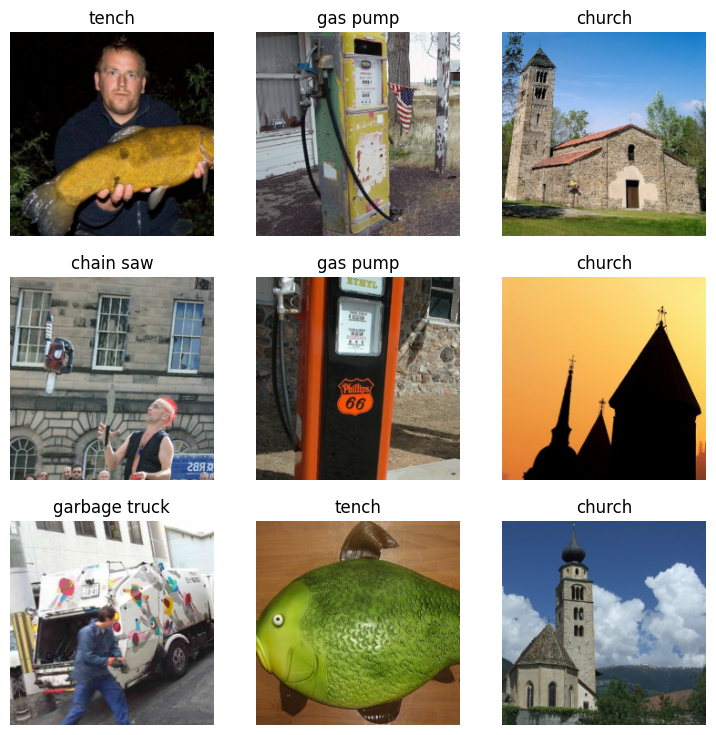

In [2]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(320),
    batch_tfms=aug_transforms(size=224),
)

dls.show_batch()

In [3]:
learn = vision_learner(dls, "convnext_tiny_in22k", metrics=accuracy).to_fp16()
learn.fine_tune(5, 5e-3)


/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.521449,5.301932,0.388889,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.530945,2.754733,0.444444,00:01
1,0.543196,1.067314,0.666667,00:01
2,0.427499,0.516807,0.888889,00:01
3,0.340091,0.503869,0.888889,00:01
4,0.266492,0.482269,0.888889,00:01


In [4]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [17]:
import pandas as pd

df = pd.read_parquet("imagenette/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [18]:
from fastai.vision.all import *
import torch

# Initialize a list to store features from all batches
all_features = []

# Define a hook function to append outputs to the list
def hook_fn(module, input, output):
    all_features.append(output.detach().cpu())  # Move to CPU to save GPU memory

# Attach the hook to the penultimate layer
penultimate_layer = learn.model[1][4]
handle = penultimate_layer.register_forward_hook(hook_fn)

# Run inference on the DataLoader
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

# Remove the hook (optional but recommended)
handle.remove()

# Concatenate all batches into a single tensor
features = torch.cat(all_features)
print(features.shape)  # Should be [30, 512]

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


torch.Size([9369, 512])


/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


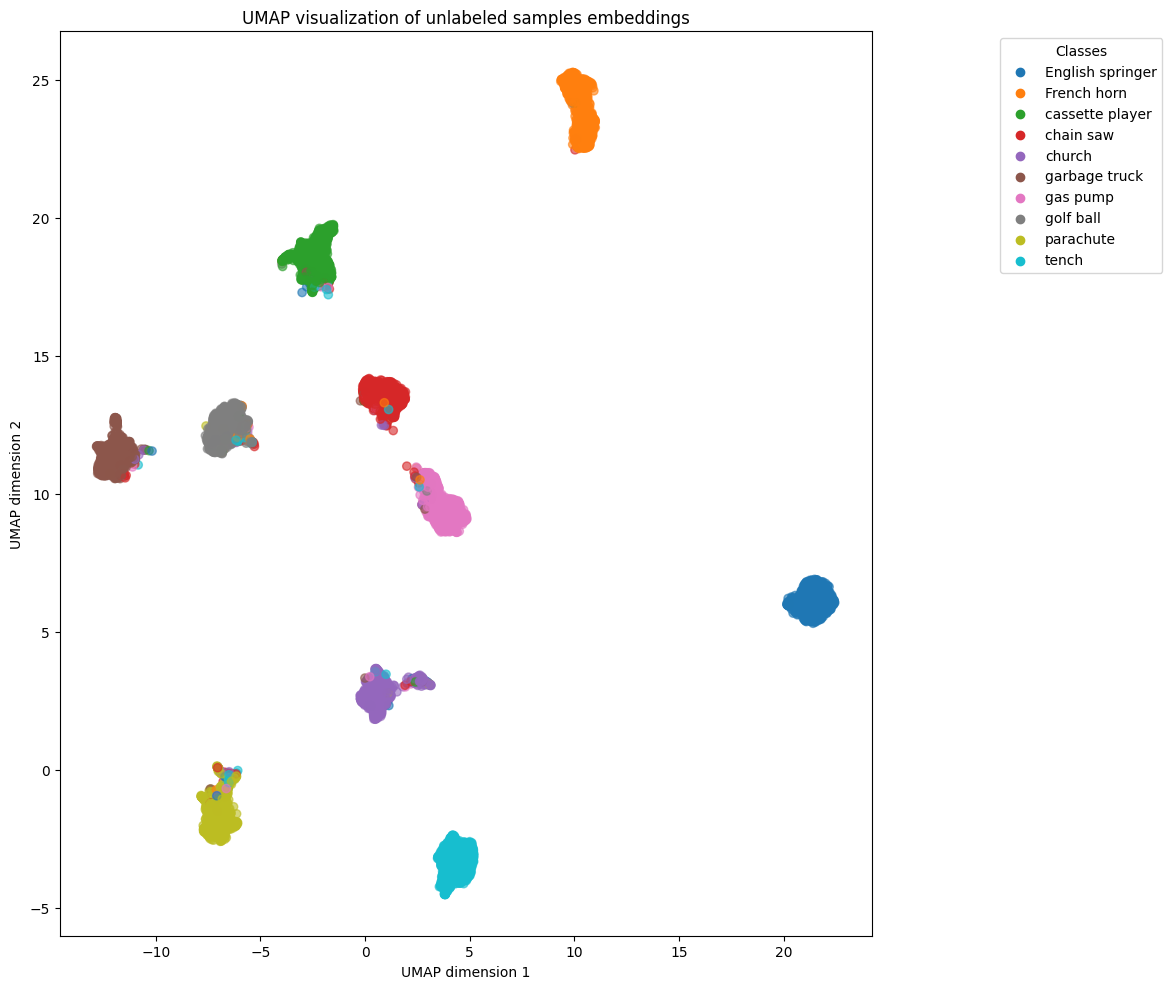

Unlabeled samples embeddings shape: torch.Size([9369, 512])


In [21]:
from umap import UMAP

# Convert to numpy and create UMAP visualization
embeddings_np = features.numpy()
labels_np = cls_preds.numpy()

# Apply UMAP instead of t-SNE
umap = UMAP(n_components=2, random_state=None, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(dls.vocab)]
plt.legend(handles=legend_elements, title="Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('UMAP visualization of unlabeled samples embeddings')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.tight_layout()
plt.show()

# Print shape of test embeddings
print(f"Unlabeled samples embeddings shape: {features.shape}")
